In [1]:
import numpy as np
import magpylib as magpy
import matplotlib.pyplot as plt

In [2]:
mu0 = 4*np.pi*1e-7 # T*m/A
gamma_h = 42.5756  # MHz/T
b_z_earth = 65E-6 # T
rho_c = 1.678E-8  # ohm*m

# Helholz Coil

In [65]:
# m axwell coil
R0 = 85# mm

# side coil distance from center
d_sc = R0/2.

R0, d_sc

n_h = 16
n_v = 14
d0 = (30.0/17) # mm wire diameter


### Generate all spirals 
spiral defined by tuple: (radius, distance from center)

In [66]:
# start wire positions
start_c_p = d_sc-(n_h)*d0/2.

print("coils z position:", f"{start_c_p:.3f}", f"{start_c_p+d0*n_h:.3f}")

# start wire radius
start_c_r = R0-(n_v)*d0/2.

# coilsposition
c_p = np.arange(start_c_p, start_c_p+d0*(n_h-1), d0)
c_r = np.arange(start_c_r, start_c_r+d0*(n_v-1), d0)


c = []

for z in c_p:
    for r in c_r:
        c.append((r, z))


print("coil radial:", f"{start_c_r:.3f}", f"{start_c_r+d0*n_v:.3f}")
len(c)

coils z position: 28.382 56.618
coil radial: 72.647 97.353


195

### Electrical Properties

In [141]:
I = 5
L_s = 0

d_copper = 0.6
for i in c:
    r, z = i
    L_s += 2*r*np.pi

print("Lunghezza filo bobina laterali:", f"{(L_s)*1e-3:.2f}", "m")
print("Lunghezza totale del filo:", f"{(2*L_s)*1e-3:.2f}", "m")


a_w = 0.25e-6 #np.power(d_copper/2., 2)*np.pi*1e-6

R = rho_c*(2*L_s)*1e-3/a_w
V = I*R

print("Resistenza totale del filo:", f"{R:.2f}", "Ohm")
print("Voltaggio Richiesto:", f"{V:.2f}", "V")
print("Potenza alimentatore:", f"{I*I*R:.2f}", "W")


Lunghezza filo bobina laterali: 101.98 m
Lunghezza totale del filo: 203.96 m
Resistenza totale del filo: 13.69 Ohm
Voltaggio Richiesto: 68.45 V
Potenza alimentatore: 342.25 W


### Computing with magpylib

In [142]:
import matplotlib.pylab as pl
from matplotlib.colors import ListedColormap

cmap = pl.cm.Greys
my_cmap = cmap(np.arange(cmap.N))
my_cmap[:,-1] = np.linspace(0.0, 1.0, cmap.N)
my_cmap_grey = ListedColormap(my_cmap)

cmap = pl.cm.jet
my_cmap = cmap(np.arange(cmap.N))
my_cmap[:,-1]*=0.4
my_cmap_jet = ListedColormap(my_cmap)

cmap = pl.cm.turbo
my_cmap = cmap(np.arange(cmap.N))
my_cmap[:,-1] = 0.6
my_cmap_turbo = ListedColormap(my_cmap)

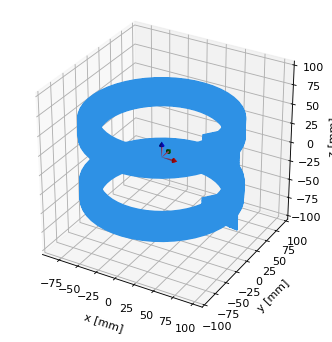

In [143]:
coils = []

for i in c:
    r, z = i
    coils.append( magpy.current.Loop(current=I, diameter=2*r, position=(0, 0, z)) )
    coils.append( magpy.current.Loop(current=I, diameter=2*r, position=(0, 0, -z)) )

total_coil = coils[0]
for i in coils[1:]:
    total_coil+=i

sensor = magpy.Sensor()

fig = magpy.show(total_coil, sensor, return_fig=True)
fig.set_figwidth(5)

size = 200
ts = np.linspace(-100, 100, size)
X, Y = np.meshgrid(ts, ts)
grid = np.array([[(x,0,z) for x in ts] for z in ts])

In [144]:
# Magnetic field 3 comp in space
B = total_coil.getB(grid)

In [145]:
# magnetic field at the center
B_center = total_coil.getB(sensor)[2]
print("Magnetic Field at the center:", f"{B_center:.2f}", "mT")
B_homo = np.ones((size, size))*B_center

print("Fattore di scala terrestre B0/B_earth: ", f"{B_center/1000/b_z_earth:.2f}")
freq = gamma_h*B_center
print("Frequenza di funzionamento:", f"{freq:0.2f}", "kHz")

n = n_h*n_v
B_ideal = np.power(4./5, 1.5)*mu0*float(n)*I/R0/1e-3
print("Teorical B field:", f"{B_ideal*1000:0.2f}", "mT")

Magnetic Field at the center: 10.65 mT
Fattore di scala terrestre B0/B_earth:  163.89
Frequenza di funzionamento: 453.55 kHz
Teorical B field: 11.85 mT


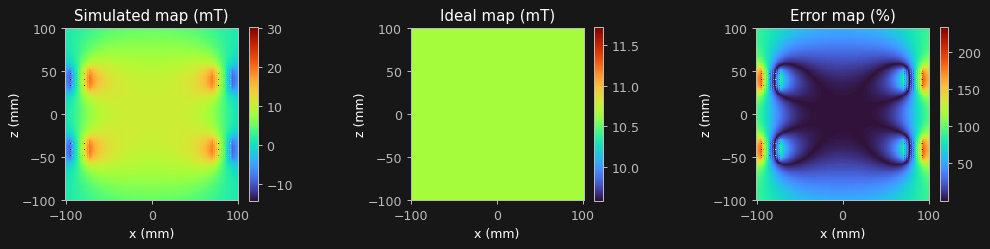

In [128]:
fig = plt.figure(figsize=(13,2.5), dpi=90, facecolor="#171717")

ax=plt.subplot(1, 3, 1)
ax.set_aspect(1)
ax.tick_params(color='#bbb', labelcolor='#bbb')
for spine in ax.spines.values():
    spine.set_edgecolor('#bbb')
p = plt.pcolor(X, Y, B[:,:,2], cmap="turbo")
cb = plt.colorbar(p)
cb.outline.set_edgecolor("#bbb")
cb.ax.tick_params(color='#bbb')
plt.setp(plt.getp(cb.ax.axes, 'yticklabels'), color="#bbb")

plt.ylabel("z (mm)", labelpad=0.1, fontdict={"color":"white"})
plt.xlabel("x (mm)", fontdict={"color":"white"})
plt.title("Simulated map (mT)", fontdict={"color":"white", "fontsize":12})

ax=plt.subplot(1, 3, 2)
ax.set_aspect(1)
ax.tick_params(color='#bbb', labelcolor='#bbb')
for spine in ax.spines.values():
    spine.set_edgecolor('#bbb')
p = plt.pcolor(X, Y, B_homo, cmap="turbo")
cb = plt.colorbar(p)
cb.outline.set_edgecolor("#bbb")
cb.ax.tick_params(color='#bbb')
plt.setp(plt.getp(cb.ax.axes, 'yticklabels'), color="#bbb")
plt.ylabel("z (mm)", labelpad=0.1,  fontdict={"color":"white"})
plt.xlabel("x (mm)", fontdict={"color":"white"})
plt.title("Ideal map (mT)", fontdict={"color":"white","fontsize":12})

err = np.abs((B_homo-B[:,:,2]))/B_center
ax=plt.subplot(1, 3, 3)
ax.set_aspect(1)
ax.tick_params(color='#bbb', labelcolor='#bbb')
for spine in ax.spines.values():
    spine.set_edgecolor('#bbb')
p = plt.pcolor(X, Y, err*100, cmap="turbo")
cb = plt.colorbar(p)
cb.outline.set_edgecolor("#bbb")
cb.ax.tick_params(color='#bbb')
plt.setp(plt.getp(cb.ax.axes, 'yticklabels'), color="#bbb")
plt.ylabel("z (mm)", labelpad=-0.2, fontdict={"color":"white"})
plt.xlabel("x (mm)", fontdict={"color":"white"})
plt.title("Error map (%)", fontdict={"color":"white","fontsize":12})

plt.subplots_adjust(wspace=0.6)
plt.show()


c:\Users\Davide\.conda\envs\mayavi_venv\lib\site-packages\matplotlib\patches.py:3389: RuntimeWarning: invalid value encountered in double_scalars
  cos_t, sin_t = head_length / head_dist, head_width / head_dist


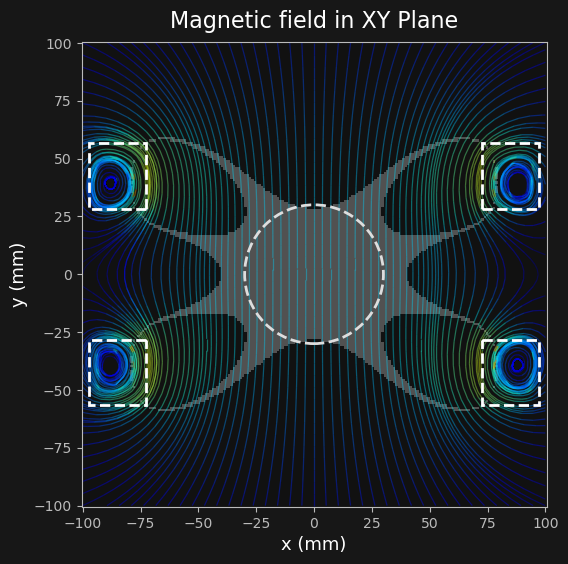

In [134]:
fig = plt.figure(figsize=(6, 8), facecolor="#171717")

ax =  fig.subplots(1, 1)
ax.set_aspect(1)

ax.tick_params(color='#bbb', labelcolor='#bbb')
for spine in ax.spines.values():
    spine.set_edgecolor('#bbb')

l = ax.streamplot(
    grid[:,:,0], grid[:,:,2], B[:,:,0], B[:,:,2], 
    color=np.linalg.norm(B, axis=2), 
    linewidth=0.9, #0.2*np.linalg.norm(np.power(np.abs(B), 1.1), axis=2),
    density=1.3,
    cmap=my_cmap_jet, 
    zorder=-2, 
    arrowsize = 0,
    broken_streamlines=False)

ax.set_facecolor("#171717")

r = 30
# ax.add_artist(plt.Circle((0, 0), r, alpha=0.3, linewidth=0, color="#ce5449", zorder=-2))
ax.add_artist(plt.Circle((0, 0), r, fill=False, linewidth=2, linestyle="dashed", zorder=-2, edgecolor="#ddd"))
ax.pcolormesh(X, Y, err>0.02, cmap=my_cmap_grey, zorder=-4, edgecolor='none', alpha=0.25)

ax.add_artist(plt.Rectangle((start_c_r, start_c_p), d0*n_v, d0*n_h, fill=False, linestyle="dashed", edgecolor="white", linewidth=2))
ax.add_artist(plt.Rectangle((start_c_r, -start_c_p), d0*n_v, -d0*n_h, fill=False, linestyle="dashed", edgecolor="white", linewidth=2))

ax.add_artist(plt.Rectangle((-start_c_r, start_c_p), -d0*n_v, d0*n_h, fill=False, linestyle="dashed", edgecolor="white", linewidth=2))
ax.add_artist(plt.Rectangle((-start_c_r, -start_c_p), -d0*n_v, -d0*n_h, fill=False, linestyle="dashed", edgecolor="white", linewidth=2))

ax.set_xlabel("x (mm)", fontdict={"color":"white", "fontsize":13})
ax.set_ylabel("y (mm)", fontdict={"color":"white", "fontsize":13})
ax.set_title("Magnetic field in XY Plane", fontdict={"color":"white", "fontsize":16}, pad=10)
plt.show()

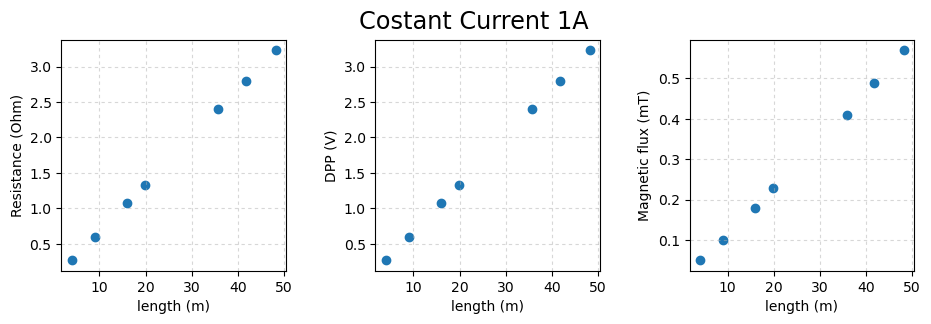

In [265]:
### Dependance of quantities
n_a = [1, 2, 3, 4, 5, 6, 7]
L_a = [3.98, 8.95, 15.91, 19.88, 35.79, 41.76, 48.17]
R_a = [0.27, 0.60, 1.07, 1.33, 2.40, 2.80, 3.23]
V_a = [0.27, 0.60, 1.07, 1.33, 2.40, 2.80, 3.23]
B_a = [0.05, 0.10, 0.18, 0.23, 0.41, 0.49, 0.57]

fig = plt.figure(figsize=(11, 3))

plt.subplot(1, 3, 1)
plt.scatter(L_a, R_a)
plt.xlabel("length (m)")
plt.ylabel("Resistance (Ohm)")
plt.grid(True, "both", alpha=0.5, linestyle=(0, (3, 3)))
plt.subplot(1, 3, 2)
plt.scatter(L_a, V_a)
plt.xlabel("length (m)")
plt.ylabel("DPP (V)")
plt.grid(True, "both", alpha=0.5, linestyle=(0, (3, 3)))
plt.subplot(1, 3, 3)
plt.scatter(L_a, B_a)
plt.xlabel("length (m)")
plt.ylabel("Magnetic flux (mT)")
plt.grid(True, "both", alpha=0.5, linestyle=(0, (3, 3)))
plt.subplots_adjust(wspace=0.4)
fig.suptitle("Costant Current 1A", fontsize="xx-large", )
plt.show()